# Imports

In [1]:
from glob import glob
import numpy as np
import xarray as xr
from starfish.core.imagestack.parser.numpy import NumpyData
from starfish.core.imagestack.imagestack import ImageStack
from itertools import combinations
import json
from starfish.types import Axes
import matplotlib.pyplot as plt
from starfish.image import ApplyTransform, LearnTransform, Filter
import json

# Variables

In [2]:
strain = "PR8"
rep = 0
hpi = 5
base_dir = f"/data/influenza-genome-packaging/results/preprocessed/{strain}/rep{rep}/{hpi}hpi"

# Functions

In [5]:
from functions import common_roi, imagestack_from_netcdf, get_ranges_from_netcdf, get_range, overlap_1d, overlap_2d, overlap_area, overlap_length, crop_overlap, registration

# Analysis

## Calculate overlaps

In [6]:
fovs = sorted(glob(f"{base_dir}/primary-fov_*.nc"))
fovs

['/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_000.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_001.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_002.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_003.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_004.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_005.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_006.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_007.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_008.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_009.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_010.nc',

In [7]:
ranges = [get_ranges_from_netcdf(f) for f in fovs]
ranges

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 271.27it/s]


[(array([0.03338273, 0.03358438]), array([0.03879404, 0.03900165])),
 (array([0.03357246, 0.0337741 ]), array([0.03879414, 0.03900165])),
 (array([0.03376218, 0.03396393]), array([0.03879424, 0.03900165])),
 (array([0.03376218, 0.03396403]), array([0.03898397, 0.03919138])),
 (array([0.03357236, 0.03377421]), array([0.03898386, 0.03919138])),
 (array([0.03338273, 0.03358458]), array([0.03898386, 0.03919138])),
 (array([0.03254299, 0.03274494]), array([0.03879563, 0.03900325])),
 (array([0.03273272, 0.03293467]), array([0.03879563, 0.03900325])),
 (array([0.03292244, 0.03312439]), array([0.03879563, 0.03900325])),
 (array([0.03292244, 0.03312439]), array([0.03898546, 0.03919298])),
 (array([0.03273272, 0.03293467]), array([0.03898546, 0.03919298])),
 (array([0.03254289, 0.03274494]), array([0.03898546, 0.03919298]))]

In [8]:
img0 = imagestack_from_netcdf(f"{base_dir}/primary-fov_000.nc")
img1 = imagestack_from_netcdf(f"{base_dir}/primary-fov_001.nc")
img0

<starfish.ImageStack (r: 3, c: 4, z: 1, y: 2017, x: 1959)>

In [9]:
xrange0 = img0.xarray.xc.values[[0,-1]]
yrange0 = img0.xarray.yc.values[[0,-1]]
xrange1 = img1.xarray.xc.values[[0,-1]]
yrange1 = img1.xarray.yc.values[[0,-1]]

100%|██████████| 12/12 [00:00<00:00, 270.17it/s]


In [10]:
overlap_2d(ranges[0], ranges[2])

(None, [0.03879424220024426, 0.0390016537])

In [11]:
overlap_area(overlap_2d(ranges[0], ranges[1]))

2.4734788239331e-09

In [12]:
overlap_area(overlap_2d(ranges[0], ranges[2]))

0.0

In [13]:
overlap_area(overlap_2d(ranges[0], ranges[0]))

4.1864889228079575e-08

In [14]:
for i1,i2 in combinations(range(len(ranges)), 2):
    r1 = ranges[i1]
    r2 = ranges[i2]
    area = overlap_area(overlap_2d(r1,r2))
    if area>0:
            print(f"{i1}, {i2}: {area}")

0, 1: 2.4734788239331e-09
0, 4: 2.1387706464521396e-10
0, 5: 3.5871893515436254e-09
1, 2: 2.4722305498691893e-09
1, 3: 2.1081569495425118e-10
1, 4: 3.5871893515436254e-09
1, 5: 2.157091327512029e-10
2, 3: 3.5682444996679427e-09
2, 4: 2.1387528567685248e-10
3, 4: 2.493590793280668e-09
4, 5: 2.5375913718091625e-09
6, 7: 2.5388299606201024e-09
6, 10: 2.1753819904857466e-10
6, 11: 3.5926653605310832e-09
7, 8: 2.5388507223658855e-09
7, 9: 2.1753997800693612e-10
7, 10: 3.5926653605310832e-09
7, 11: 2.1753819904857466e-10
8, 9: 3.5926653605310832e-09
8, 10: 2.1753997800693612e-10
9, 10: 2.5375913718091625e-09
10, 11: 2.537570620361864e-09


## Overlap graphs

In [15]:
import networkx as nx

In [16]:
G = nx.Graph()

In [17]:
for i1,i2 in combinations(range(len(ranges)), 2):
    r1 = ranges[i1]
    r2 = ranges[i2]
    area = overlap_area(overlap_2d(r1,r2))
    if area>0:
            G.add_edge(i1, i2, weight=area)

In [18]:
print(G)

Graph with 12 nodes and 22 edges


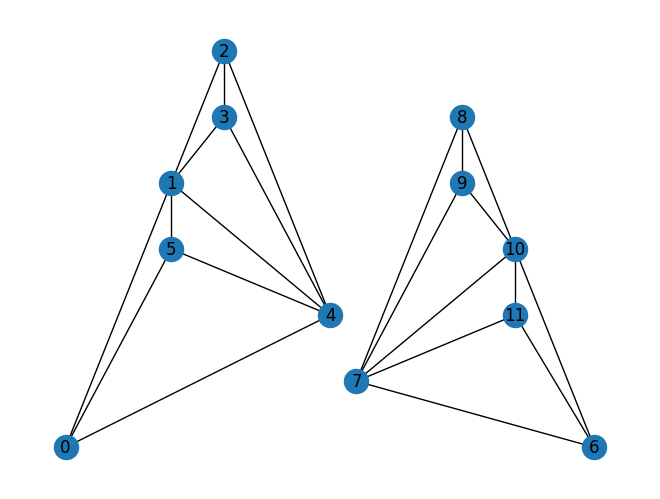

In [19]:
nx.draw_planar(G, with_labels=True)

In [20]:
manual_pos = {i: (x[0][0],x[1][0]) for i,x in enumerate(ranges)}
manual_pos

{0: (0.03338273458485588, 0.038794036230532486),
 1: (0.03357245938485589, 0.03879413921538837),
 2: (0.03376218428485589, 0.03879424220024426),
 3: (0.03376218428485589, 0.03898396700024426),
 4: (0.0335723564, 0.03898386401538837),
 5: (0.03338273458485588, 0.03898386401538837),
 6: (0.03254299028485588, 0.038795634830532486),
 7: (0.03273271518485588, 0.038795634830532486),
 8: (0.03292243998485589, 0.038795634830532486),
 9: (0.03292243998485589, 0.03898546271538837),
 10: (0.03273271518485588, 0.03898546271538837),
 11: (0.0325428873, 0.03898546271538837)}

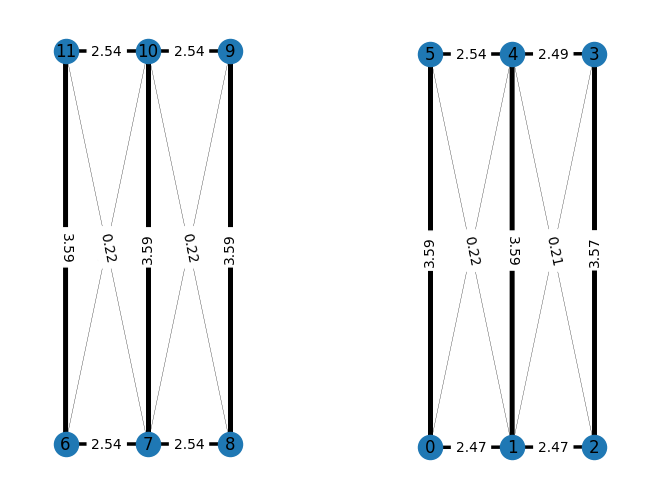

In [21]:
#pos=nx.planar_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
pos=manual_pos
labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx(G,pos,edge_color=labels.values())
labels = {x: y*1e9 for x,y in labels.items()}
nx.draw(G, pos, width=list(labels.values()),with_labels=True)
labels = {x: f"{y:.2f}" for x,y in labels.items()}
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);


## Maximum spanning tree

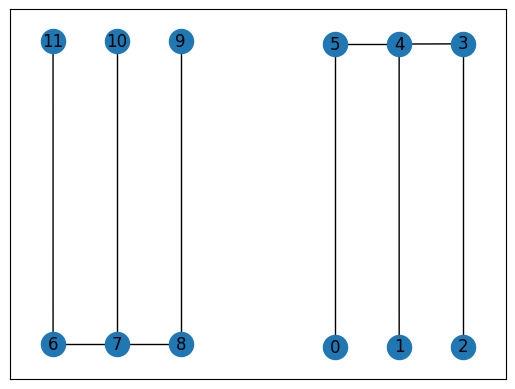

In [22]:
mst = nx.maximum_spanning_tree(G)
nx.draw_networkx(mst, manual_pos)

In [23]:
edges = list(mst.edges)
edges

[(0, 5),
 (1, 4),
 (4, 5),
 (4, 3),
 (2, 3),
 (6, 11),
 (6, 7),
 (7, 10),
 (7, 8),
 (8, 9)]

## Registration along MST edges

In [24]:
source = edges[2][0]
target = edges[2][1]
source_path = f"{base_dir}/primary-fov_0{source}.nc" if source >= 10 else f"{base_dir}/primary-fov_00{source}.nc"
target_path = f"{base_dir}/primary-fov_0{target}.nc" if target >= 10 else f"{base_dir}/primary-fov_00{target}.nc"
source_img = xr.open_dataset(source_path).__xarray_dataarray_variable__
target_img = xr.open_dataset(target_path).__xarray_dataarray_variable__
source_max = source_img.max(dim=["r", "c"]).squeeze()
target_max = target_img.max(dim=["r", "c"]).squeeze()

In [25]:
px_size_x1 = source_img.xc.values[1] - source_img.xc.values[0]
px_size_y1 = source_img.yc.values[1] - source_img.yc.values[0]
px_size_x2 = target_img.xc.values[1] - target_img.xc.values[0]
px_size_y2 = target_img.yc.values[1] - target_img.yc.values[0]

if px_size_x1 != px_size_x2 or px_size_y1 != px_size_y2 or px_size_x1 != px_size_x2:
    print("WARNING: pixel sizes differ between source_img and target_img")

In [26]:
range_source, range_target = get_range(source_img), get_range(target_img)
mp_ov1, mp_ov2 = crop_overlap(source_max, target_max, range_source, range_target)
mp_ov1

<xarray.DataArray '__xarray_dataarray_variable__' (y: 2015, x: 118)>
array([[0.00826574, 0.00295141, 0.02005898, ..., 0.00491332, 0.        ,
        0.        ],
       [0.00962758, 0.0013062 , 0.00304668, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00158713, 0.        , ..., 0.        , 0.00175314,
        0.        ],
       ...,
       [0.00074108, 0.00393577, 0.00168236, ..., 0.01692924, 0.00976048,
        0.00810913],
       [0.        , 0.00599805, 0.00043845, ..., 0.00679656, 0.00980104,
        0.00145056],
       [0.00430982, 0.00030262, 0.00665457, ..., 0.01342145, 0.01047073,
        0.0071364 ]], dtype=float32)
Coordinates:
    yc       (y) float64 0.03898 0.03898 0.03898 ... 0.03919 0.03919 0.03919
    xc       (x) float64 0.03357 0.03357 0.03357 ... 0.03358 0.03358 0.03358
    z        int32 0
    zc       float64 ...
Dimensions without coordinates: y, x

In [27]:
tx_px, ty_px = registration(mp_ov1, mp_ov2)
tx = tx_px * px_size_x1
ty = ty_px * px_size_y1
tx_px, ty_px

100%|██████████| 2/2 [00:00<00:00, 740.39it/s]


(-8.871000289916992, -7.543000221252441)

In [28]:
## Registration
# Cut out the overlap area of both MIPs
mps_ov = []

for i, fov, fov_idx, c in [(1, mp1, fov1_idx, "green"), (2, mp2, fov2_idx, "red")]:
    x_idx = np.where((fov.xc.values >= x_overlap[0]) & (fov.xc.values <= x_overlap[1]))[0]
    y_idx = np.where((fov.yc.values >= y_overlap[0]) & (fov.yc.values <= y_overlap[1]))[0]

    fov_ov = fov.sel(
        x = slice(x_idx[0], x_idx[-1]),
        y = slice(y_idx[0], y_idx[-1])
    )

    mps_ov.append(fov_ov)

    viewer.add_image(fov_ov, translate=[fov_ov.yc.values[0], fov_ov.xc.values[0]], scale=scale, name=f"FOV{i} overlap", colormap=c, blending="additive")

# Registration
mp_ov1, mp_ov2 = mps_ov

stack_np = np.stack([mp_ov1.values, mp_ov2.values], axis=0)
stack_np = stack_np[:, np.newaxis, np.newaxis, :, :]
stack_both = ImageStack.from_numpy(stack_np)

learn_translation = LearnTransform.Translation(reference_stack=stack_both.sel({Axes.ROUND: 0}), axes=Axes.ROUND, upsampling=1000) ## Registration
warp = ApplyTransform.Warp()
transform_list = learn_translation.run(stack_both)
registered_stack = warp.run(stack_both, transforms_list=transform_list)
transform_list.to_json(f"registration.json")

with open(f"registration.json", "r", encoding="utf-8") as file_reg:
    dict_reg = json.load(file_reg)

tx = dict_reg["transforms_list"][1][2][0][2] * -1 * px_size_x1
ty = dict_reg["transforms_list"][1][2][1][2] * -1 * px_size_y1

NameError: name 'mp1' is not defined

# To do

Registration differs between napari script and this script